In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from pprint import pprint
from pylab import *
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util
sys.path.append('../..')
import data_manipulations as manip

%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
DATA_PATH =  '../../../data/cluster/year/'
[f for f in os.listdir(DATA_PATH) if 'full' in f]

['X_test_full.csv',
 'X_train_full.csv',
 'X_valid_full.csv',
 'y_test_full.csv',
 'y_train_full.csv',
 'y_valid_full.csv']

In [3]:
X_train = pd.read_csv(DATA_PATH + 'X_train_full.csv')
X_valid = pd.read_csv(DATA_PATH + 'X_valid_full.csv')
X_test  = pd.read_csv(DATA_PATH + 'X_test_full.csv')
y_train = pd.read_csv(DATA_PATH + 'y_train_full.csv')
y_valid = pd.read_csv(DATA_PATH + 'y_valid_full.csv')
y_test  = pd.read_csv(DATA_PATH + 'y_test_full.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_valid = X_valid.drop(['Unnamed: 0'], axis=1)
X_test  = X_test.drop(['Unnamed: 0'],  axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_valid = y_valid.drop(['Unnamed: 0'], axis=1)
y_test  = y_test.drop(['Unnamed: 0'],  axis=1)


print('train: X %s\t y%s' % (X_train.shape, y_train.shape))
print('valid: X %s\t y%s' % (X_valid.shape, y_valid.shape))
print('test:  X %s\t y%s' % (X_test.shape,  y_test.shape))

train: X (529623, 25)	 y(529623, 1)
valid: X (117694, 25)	 y(117694, 1)
test:  X (117694, 25)	 y(117694, 1)


In [4]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.23%
Percent presence in y_valid: 13.29%
Percent presence in y_test: 12.54%


In [5]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [6]:
np.isfinite(X_valid).all()

year                        True
meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
studyArea                   True
elev_srtm30                 True
x                           True
y                           True
next_year_beetle            True
dtype: bool

In [7]:
print('X_train:', 
      np.isnan(X_train.varPrecip_growingSeason).sum() / X_train.shape[0])
print('X_valid:', 
      np.isnan(X_valid.varPrecip_growingSeason).sum() / X_valid.shape[0])
print('X_test:',  
      np.isnan(X_test.varPrecip_growingSeason).sum() / X_test.shape[0])

X_train: 0.00350626766587
X_valid: 0.00817373867827
X_test: 0.00188624738729


In [8]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

(527766, 25) (527766, 1)
(116732, 25) (116732, 1)
(117472, 25) (117472, 1)


In [9]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [10]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_test  = X_test.drop(['studyArea',  'x', 'y', 'elev_srtm30', 'year'],  axis=1)

In [11]:
predictors = list(X_train)
predictors

['meanTemp_Annual',
 'meanTemp_AprAug',
 'meanTemp_Aug',
 'meanMinTemp_DecFeb',
 'meanMinTemp_Oct',
 'meanMinTemp_Jan',
 'meanMinTemp_Mar',
 'meanMaxTemp_Aug',
 'precip_meanAnnual',
 'precip_JunAug',
 'vegetation',
 'precipPrevious_JunAug',
 'precip_OctSep',
 'precipPrevious_OctSep',
 'precip_growingSeason',
 'varPrecip_growingSeason',
 'elev_etopo1',
 'lat',
 'lon',
 'next_year_beetle']

In [12]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [13]:
y_train = util.vectorize(y_train.as_matrix())
y_valid = util.vectorize(y_valid.as_matrix())
y_test  = util.vectorize(y_test.as_matrix())

# Neural Net Model

In [14]:
best_val_loss = np.inf
X_train.shape

(527766, 20)

In [15]:
# Params and Hyperparams
n_inputs = X_train.shape[1]
n_outputs = 2

# Current best
#N_LAYERS = 3
#NODES_PER_LAYER = ([n_inputs] * N_LAYERS)
NODES_PER_LAYER = [
    n_inputs, n_inputs * 2, n_inputs * 4, n_inputs * 8, n_inputs * 8, 
    n_inputs * 8, n_inputs * 8, n_inputs * 8, n_inputs * 4, n_inputs * 2, 
    n_inputs]
NODES_PER_LAYER.append(n_outputs)
ETA = 0.1
DROPOUT = 0.5
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.01
EPOCHS = 124
BATCH_SIZE = 1024

NODES_PER_LAYER

[20, 40, 80, 160, 160, 160, 160, 160, 80, 40, 20, 2]

In [16]:
def get_params():
    return {'NODES_PER_LAYER': NODES_PER_LAYER,
            'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE}

In [17]:
model = Sequential()

# NOTE: "glorot-normal" is the same thing as "Xavier" initialization
model.add(Dense(NODES_PER_LAYER[1], 
                input_dim=NODES_PER_LAYER[0], 
                kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

# additional hidden layers here
for i in range(2, len(NODES_PER_LAYER) - 1):
    model.add(Dense(NODES_PER_LAYER[i], 
                    kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

model.add(Dense(NODES_PER_LAYER[-1], kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                3280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 80)                320       
_________________________________________________________________
activation_2 (Activation)    (None, 80)                0         
__________

In [18]:
adam = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(
    loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [28]:
VERBOSE = 1
checkpointer = ModelCheckpoint(filepath=DATA_PATH + 'weights.bestNN.hdf5',
                               verbose=VERBOSE,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=EPOCHS / 2)
start = time.time()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpointer], #, earlyStop],
                    verbose=VERBOSE)
elapsed = time.time() - start
print('Time: %.2f minutes' % (elapsed / 60))

Train on 527766 samples, validate on 116732 samples
Epoch 1/124
527766/527766 [==============================] - 74s 139us/step - loss: 0.2422 - acc: 0.9127 - val_loss: 0.2160 - val_acc: 0.9278
Epoch 2/124
527766/527766 [==============================] - 72s 137us/step - loss: 0.2360 - acc: 0.9149 - val_loss: 0.2303 - val_acc: 0.9289
Epoch 3/124
527766/527766 [==============================] - 74s 140us/step - loss: 0.2325 - acc: 0.9165 - val_loss: 0.2307 - val_acc: 0.9268
Epoch 4/124
527766/527766 [==============================] - 73s 139us/step - loss: 0.2302 - acc: 0.9170 - val_loss: 0.2319 - val_acc: 0.9260
Epoch 5/124
527766/527766 [==============================] - 74s 140us/step - loss: 0.2292 - acc: 0.9176 - val_loss: 0.2408 - val_acc: 0.9273
Epoch 6/124
527766/527766 [==============================] - 74s 141us/step - loss: 0.2281 - acc: 0.9180 - val_loss: 0.2353 - val_acc: 0.9269
Epoch 7/124
527766/527766 [==============================] - 75s 141us/step - loss: 0.2263 - acc

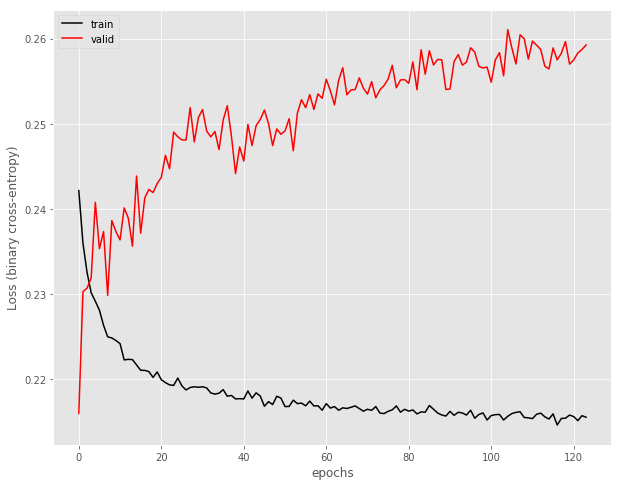

In [29]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (binary cross-entropy)')
#plt.yscale('log');
plt.legend(loc='best');

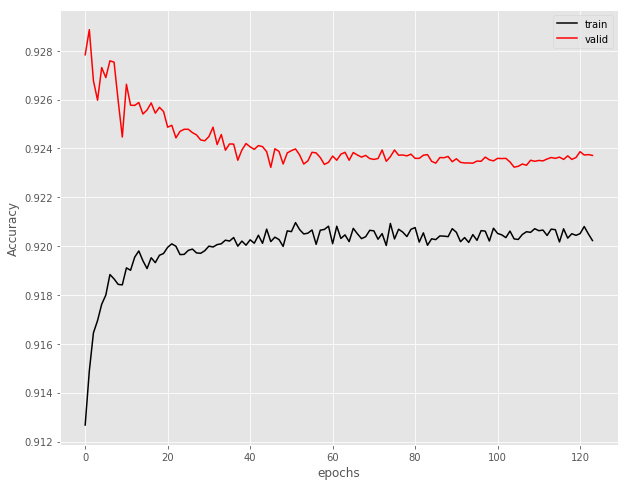

In [30]:
plt.plot(history.history['acc'], 'k-', label='train');
plt.plot(history.history['val_acc'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Accuracy')
#plt.yscale('log');
plt.legend(loc='best');

In [31]:
this_run = np.mean(history.history['val_loss'][-50:])
print('This run: %.5f' % this_run)

if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    train_loss_of_best = np.mean(history.history['loss'][-50:])
    best_params = get_params()
print('Best validation loss so far: %.5f' % best_val_loss)
print('Training loss of same model: %.5f' % train_loss_of_best)
print('Best hyperparameters found so far:')
pprint(best_params)

This run: 0.25729
Best validation loss so far: 0.19070
Training loss of same model: 0.27901
Best hyperparameters found so far:
{'BATCH_SIZE': 1024,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'DECAY': 0.01,
 'DROPOUT': 0.5,
 'EPOCHS': 124,
 'EPSILON': 1e-08,
 'ETA': 0.1,
 'NODES_PER_LAYER': [20, 40, 80, 160, 160, 160, 160, 160, 80, 40, 20, 2]}


In [32]:
preds = model.predict(X_test)
pred_probs = util.preds2probs(preds)
preds = util.one_cold(util.binarize(preds))
y_test_cold = util.one_cold((y_test))
cm = util.make_confusion_matrix(y_test_cold, pred_probs, 0.5)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	11088		3670
        0	4595		98119


In [33]:
metrics = util.get_metrics(cm)

Accuracy:  0.929642808499
Precision: 0.707007587834
Recall:    0.751321317252
F1:        0.728491179659


In [34]:
auc_metrics = util.get_auc(y_test_cold, pred_probs)

AUC:       0.952086056931


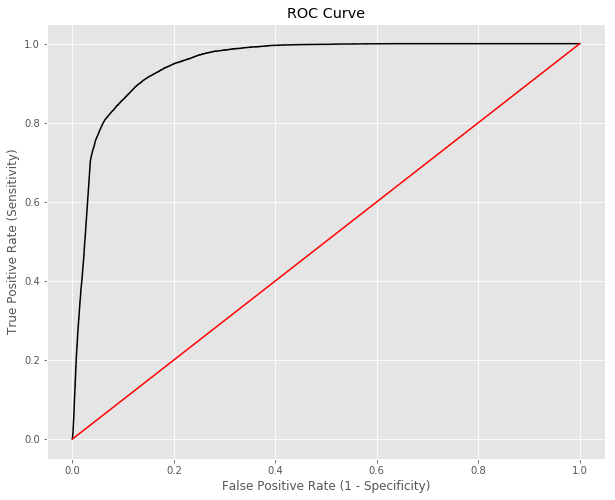

In [35]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [201]:
def column2matrix(dataframe, column, cell_dim=10000):
    '''                                                                          
    Convert a column from DataFrame df into a matrix representation with the     
    upper-left cell indexing beginning at [0, 0].                                
    It is expected that the DataFrame has columns x and y.                       
                                                                                 
    Args:                                                                        
    df: DataFrame: the source data                                               
    column: string: the column name to extract                                   
    cel_dim: numeric: the dimensions of each grid cell                           
                                                                                 
    Returns: np.ndarray (a 2D list; matrix)                                      
    '''
    df = dataframe.copy()
    x_min = df.x.min()
    y_min = df.y.min()
    df.x -= x_min
    df.y -= y_min
    xs = sorted(df.x.unique())
    ys = sorted(df.y.unique())
    matrix = np.array([[np.nan for y in range(len(ys))]
                       for x in range(len(xs))])

    for row in df.index:
        x, y, value = df.loc[row, ['x', 'y', column]]
        i = int((x - xs[0]) / cell_dim)
        j = int((y - ys[0]) / cell_dim)
        matrix[i, j] = value

    return matrix

In [202]:
#print(len(y_test_cold))
#print(full_test.shape)
full_test['preds'] = preds
full_test.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,varPrecip_growingSeason,elev_etopo1,lat,lon,studyArea,elev_srtm30,x,y,beetle,preds
0,2000,17.057845,18.892138,21.608865,4.831345,10.825336,6.119776,7.627907,27.147665,7.199924,...,0.674441,52,30.505152,-116.039726,1,-2,-1550000.0,-2000000.0,0,0
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,0.790828,17,30.523203,-115.938118,1,17,-1540000.0,-2000000.0,0,0
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,1.732051,151,30.541141,-115.836475,1,74,-1530000.0,-2000000.0,0,0
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,0.172152,500,30.558965,-115.734797,1,466,-1520000.0,-2000000.0,0,0
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,0.364632,564,30.576676,-115.633085,1,568,-1510000.0,-2000000.0,0,0


In [203]:
test_2000 = full_test.loc[full_test.year == 2000, :]
test_2001 = full_test.loc[full_test.year == 2001, :]
test_2002 = full_test.loc[full_test.year == 2002, :]
test_2000.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,varPrecip_growingSeason,elev_etopo1,lat,lon,studyArea,elev_srtm30,x,y,beetle,preds
0,2000,17.057845,18.892138,21.608865,4.831345,10.825336,6.119776,7.627907,27.147665,7.199924,...,0.674441,52,30.505152,-116.039726,1,-2,-1550000.0,-2000000.0,0,0
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,0.790828,17,30.523203,-115.938118,1,17,-1540000.0,-2000000.0,0,0
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,1.732051,151,30.541141,-115.836475,1,74,-1530000.0,-2000000.0,0,0
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,0.172152,500,30.558965,-115.734797,1,466,-1520000.0,-2000000.0,0,0
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,0.364632,564,30.576676,-115.633085,1,568,-1510000.0,-2000000.0,0,0


In [204]:
beetle_2000_matrix = column2matrix(test_2000, 'beetle')

In [205]:
pred_2000_matrix = column2matrix(test_2000, 'preds')
error_matrix = pred_2000_matrix - beetle_2000_matrix

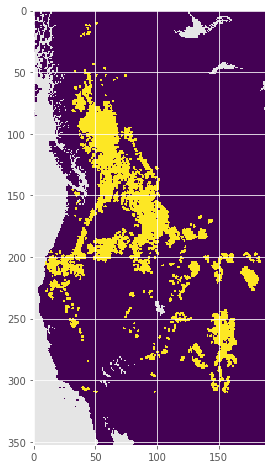

In [209]:
imshow(np.rot90(beetle_2000_matrix));

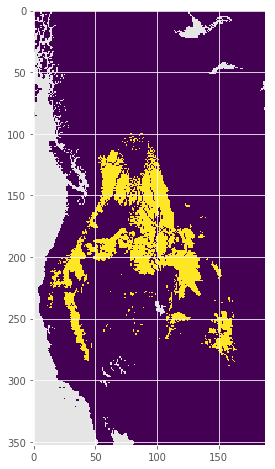

In [210]:
imshow(np.rot90(pred_2000_matrix));

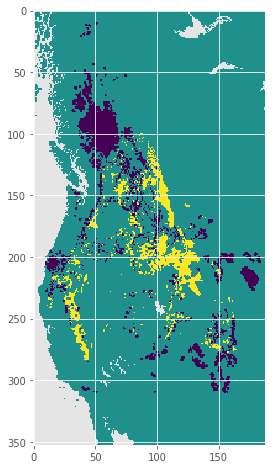

In [212]:
imshow(np.rot90(error_matrix));

In [213]:
beetle_2002_matrix = column2matrix(test_2002, 'beetle')
pred_2002_matrix = column2matrix(test_2002, 'preds')
error_matrix_2002 = pred_2002_matrix - beetle_2002_matrix

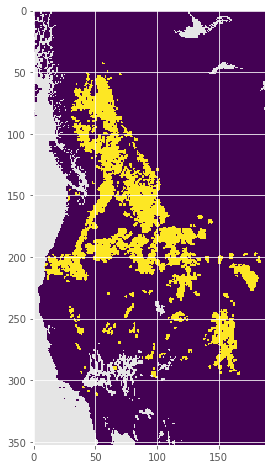

In [214]:
imshow(np.rot90(beetle_2002_matrix));

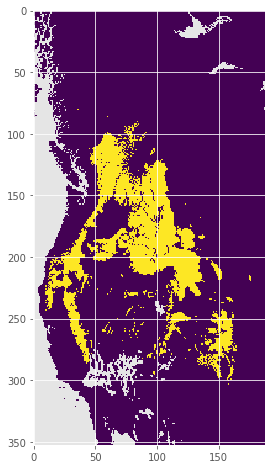

In [215]:
imshow(np.rot90(pred_2002_matrix));

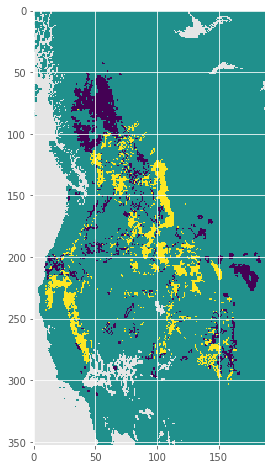

In [216]:
imshow(np.rot90(error_matrix_2002));

In [220]:
list(test_2000)

['year',
 'meanTemp_Annual',
 'meanTemp_AprAug',
 'meanTemp_Aug',
 'meanMinTemp_DecFeb',
 'meanMinTemp_Oct',
 'meanMinTemp_Jan',
 'meanMinTemp_Mar',
 'meanMaxTemp_Aug',
 'precip_meanAnnual',
 'precip_JunAug',
 'vegetation',
 'precipPrevious_JunAug',
 'precip_OctSep',
 'precipPrevious_OctSep',
 'precip_growingSeason',
 'varPrecip_growingSeason',
 'elev_etopo1',
 'lat',
 'lon',
 'studyArea',
 'elev_srtm30',
 'x',
 'y',
 'beetle',
 'preds']

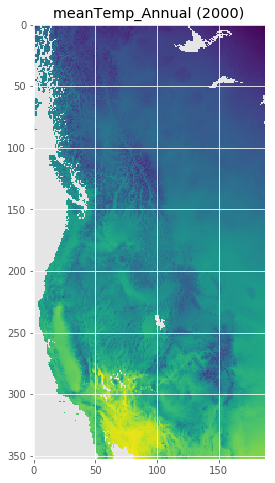

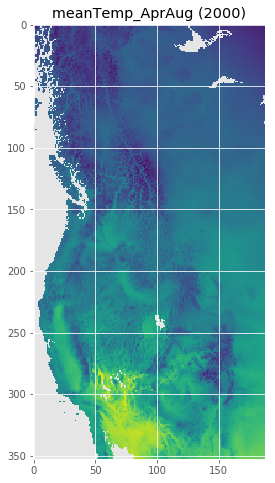

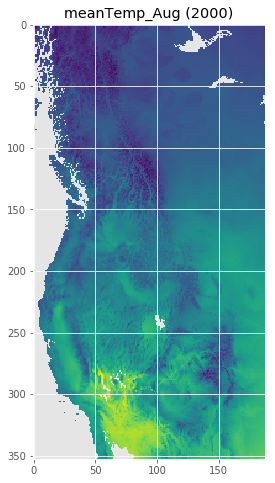

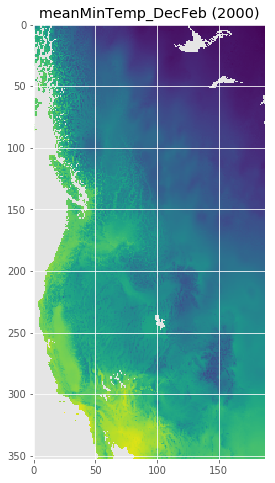

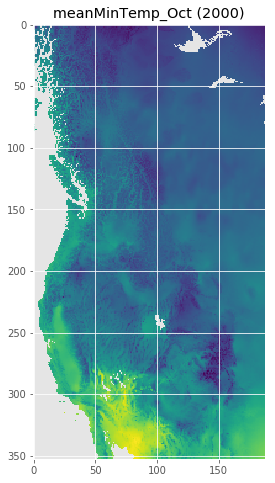

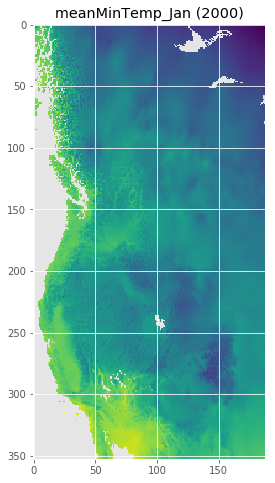

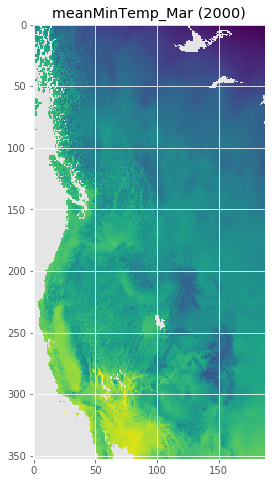

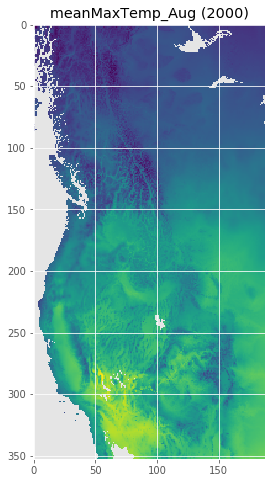

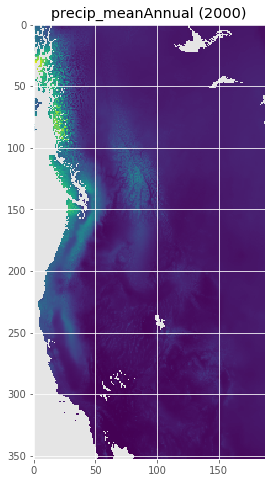

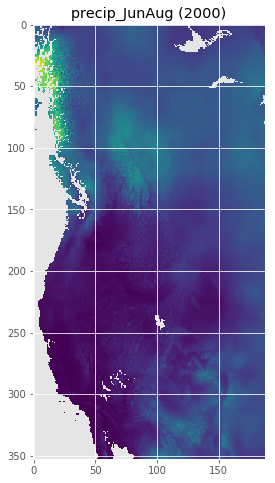

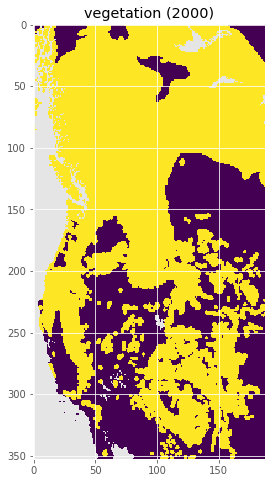

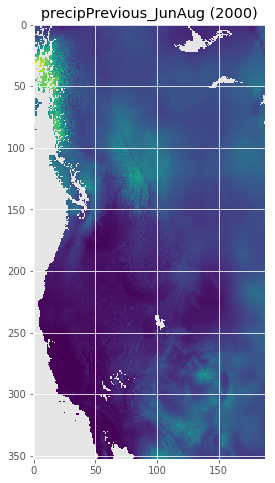

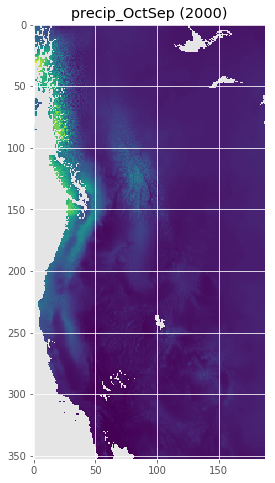

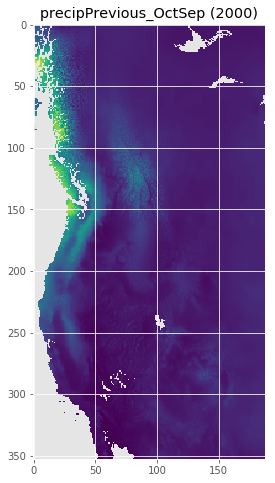

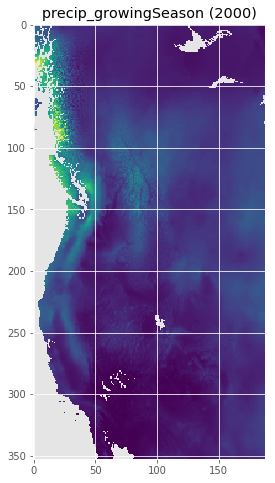

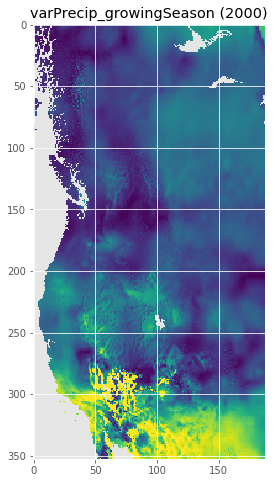

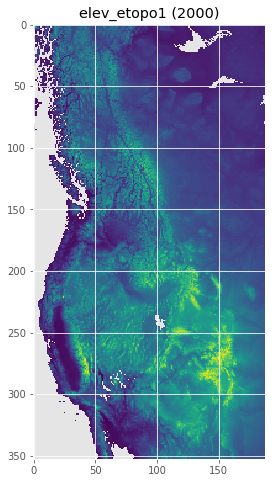

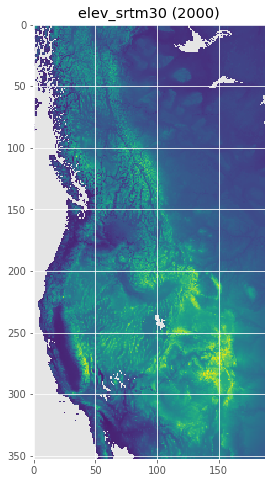

In [223]:
fields = [
    'meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 
    'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan',
    'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 
    'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 
    'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason',
    'varPrecip_growingSeason', 'elev_etopo1']
for field in fields:
    field_2000_matrix = column2matrix(test_2000, field)
    plt.figure();
    imshow(np.rot90(field_2000_matrix));
    plt.title(field + ' (2000)');
    plt.show();